In [9]:
#Every time opening this notebook, run this cell and click "Allow". 
#May not need to run again after command "restart runtime".
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
'''2022Oct25, load clean PSD from *.mat files. 6 modulations, each has 10 random clean PSDs
Mar 16 2022, Generator for clean PSD data (QAM, MSK, GMSK), simplified code 
toolboxes Copyed from old datagenerator, may be redundant'''  
import csv
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import time
import heapq
import torch
import os
import math
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.distributed as TUDdistributed
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from utils import progress_bar
from torch.autograd import Variable
import sys
from copy import deepcopy
import random
import collections
from scipy import signal
# import commpy
# import commpy.filters as filters
import scipy.io as scio

device = torch.device("cuda")
#use_cuda = True
criterion = nn.CrossEntropyLoss()

In [11]:
def imshow(img, max_val):
    #function for graphing
    #img = img / 2 + 0.5 #unnormalize if needed
    # npimg = img.numpy()
    # npimg = img
    #plt.imshow(np.transpose(npimg, cmap = 'gray', interpolation='nearest' ))
    plt.rcParams['figure.figsize'] = (12., 8.)
    plt.imshow(-1*img , cmap = 'gray', vmin = -1*max_val, vmax = 0.0, interpolation='nearest'   )# notice it's negative
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.axis('off')
    plt.show()

In [12]:
# Oct 30, 2FSK, 4FSK, BPSK, 16PSK, MSK, 16QAM, try ot be different
span = 64 #PSD dim, 128 for journal, 64 for toy Transformer
dir = '/content/drive/MyDrive/Wireless_Transformer/SpectrumLib/'
# data = scio.loadmat(filePATH)
# data is un-normalized PSD vector
def load_mod(mod,i):
  #mod: string about dir, actually mod type
  #i: index
  spectrum = scio.loadmat(dir+mod+str(i+1)+'.mat')['spectrum']
  pw=np.average(spectrum[64:128])
  return spectrum/pw

cleanPSD = {
    'Description': 'from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length ='+str(span) +', type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs',
    1: [ load_mod('BPSK/BPSK',i) for i in range(10) ],
    2: [ load_mod('MSK/MSK',i) for i in range(10) ],
    3: [ load_mod('FSK/2FSK',i) for i in range(10) ],
    4: [ load_mod('16PSK/16PSK',i) for i in range(10) ],
    5: [ load_mod('FSK/4FSK',i) for i in range(10) ],
    6: [ load_mod('QAM/16QAM',i) for i in range(10) ],
}

# cleanPSD = {
#     'Description': 'from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length ='+str(span) +', type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs',
#     1: [ scio.loadmat(dir+'BPSK/BPSK'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
#     2: [ scio.loadmat(dir+'QPSK/QPSK'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
#     3: [ scio.loadmat(dir+'8PSK/8PSK'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
#     4: [ scio.loadmat(dir+'16PSK/16PSK'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
#     5: [ scio.loadmat(dir+'FSK/4FSK'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
#     6: [ scio.loadmat(dir+'QAM/16QAM'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
# }

# Set address, either on local or mounted on drive
#If mounted to drive and will save the clean PSDs to drive
address = '/content/drive/MyDrive/Wireless_Transformer/'
name = 'clean_PSD_6mod_Mat.pth'
torch.save(cleanPSD, address+name )
#Check saved PSDs
print('saved_address:\n'+ address+name )
print( torch.load(address+name)['Description'])

saved_address:
/content/drive/MyDrive/Wireless_Transformer/clean_PSD_6mod_Mat.pth
from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length =64, type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs


192

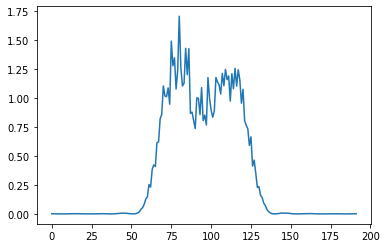

In [20]:
plt.plot(torch.load(address+name)[6][7])
torch.load(address+name)[2][8].size

dict_keys(['__header__', '__version__', '__globals__', 'spectrum'])


64

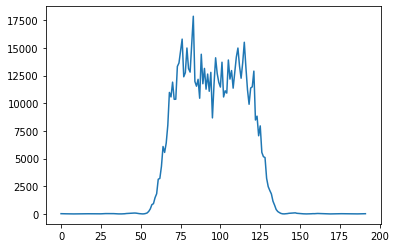

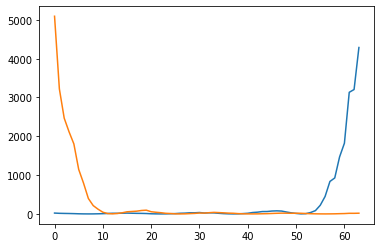

In [21]:
'''Testing mat data'''

filePATH = '/content/drive/MyDrive/Wireless_Transformer/SpectrumLib/QPSK/QPSK7.mat'
data = scio.loadmat(filePATH)
print(data.keys())
plt.figure(1)
plt.plot(data['spectrum'])
type(data['spectrum'])
# shape(data['spectrum'])
left = data['spectrum'][0:64]
right = data['spectrum'][-64:192]
plt.figure(2)
plt.plot(left)
plt.plot(right)
# data['spectrum'].size
right.size
# left.size

In [8]:
dir = '/content/drive/MyDrive/Wireless_Transformer/SpectrumLib/'
qpsktuple=[ scio.loadmat(dir+'QPSK/QPSK'+str(i+1)+'.mat') for i in range(10) ]
print(len(qpsktuple))

10


In [5]:
# Oct 29-30
# 4 types of PSK, MSK and FSK  
span = 64 #PSD dim, 128 for journal, 64 for toy Transformer
dir = '/content/drive/MyDrive/Wireless_Transformer/SpectrumLib/'
# data = scio.loadmat(filePATH)
# data is un-normalized PSD vector
def load_mod(mod,i):
  #mod: string about dir, actually mod type
  #i: index
  spectrum = scio.loadmat(dir+mod+str(i+1)+'.mat')['spectrum']
  pw=np.average(spectrum[64:128])
  return spectrum/pw

cleanPSD = {
    'Description': 'from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length ='+str(span) +', type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs',
    1: [ load_mod('BPSK/BPSK',i) for i in range(10) ],
    2: [ load_mod('QPSK/QPSK',i) for i in range(10) ],
    3: [ load_mod('8PSK/8PSK',i) for i in range(10) ],
    4: [ load_mod('16PSK/16PSK',i) for i in range(10) ],
    5: [ load_mod('FSK/4FSK',i) for i in range(10) ],
    6: [ load_mod('QAM/16QAM',i) for i in range(10) ],
}

# cleanPSD = {
#     'Description': 'from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length ='+str(span) +', type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs',
#     1: [ scio.loadmat(dir+'BPSK/BPSK'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
#     2: [ scio.loadmat(dir+'QPSK/QPSK'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
#     3: [ scio.loadmat(dir+'8PSK/8PSK'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
#     4: [ scio.loadmat(dir+'16PSK/16PSK'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
#     5: [ scio.loadmat(dir+'FSK/4FSK'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
#     6: [ scio.loadmat(dir+'QAM/16QAM'+str(i+1)+'.mat')['spectrum'] for i in range(10) ],
# }

# Set address, either on local or mounted on drive
#If mounted to drive and will save the clean PSDs to drive
address = '/content/drive/MyDrive/Wireless_Transformer/'
name = 'clean_PSD_6mod_Mat.pth'
torch.save(cleanPSD, address+name )
#Check saved PSDs
print('saved_address:\n'+ address+name )
print( torch.load(address+name)['Description'])

saved_address:
/content/drive/MyDrive/Wireless_Transformer/clean_PSD_6mod_Mat.pth
from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length =64, type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs
